# Crimes in CDMX / *Delitos en CDMX*

This work intents to analyze crimes in three faces / *Este trabajo intenta analizar los delitos en tres partes*:  
- Top crimes types / *Principales tipos de delitos*  
- Top neighborhoods per crimes type / *Principales colonias por tipo de delito*
- Neighborhoods clusters per crime rate / *Grupos de colonias por índice de delitos*

## Table of Contents / *Tabla de contenidos*

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Installing Tools / *Instalando Herramientas*](#0)<br>
2. [Downloading and Preparing Data / *Bajando y Preparando los Datos*](#2)<br>
3. [Analyzing the Data / *Analizando los Datos*](#4) <br>
4. [Map with Markers / *Mapa con Marcadores*](#6) <br>
</div>
<hr>

# 1. Installing Tools / *Instalando Herramientas*<a id="0"></a>

In [1]:
# Install Beautiful Soup
import sys
# Install Geopy, Folium and Beautiful Soup
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install xlrd
print('Installation done')

     |████████████████████████████████| 112kB 14.1MB/s eta 0:00:01
Installation done


In [2]:
# Install tools
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from IPython.display import Image 
from IPython.core.display import HTML 
from botocore.client import Config

import types
import ibm_boto3
import pandas as pd
import numpy as np
import requests
import os
import codecs
import requests # library to handle requests
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files
import folium # map rendering library

print('Tools imported.')

Tools imported.


# 2. Downloading and Preparing Data / *Bajando y Preparando los Datos*<a id="2"></a>

#### 2.1 Import crimes files and load files of neighborhoods and crimes / *Importar archivo de delitos y cargar archivos de colonias y delitos*

In [3]:
# Import the csv file of colonias
coloniascdmx = pd.read_csv('coloniascdmx.csv')
coloniascdmx.head()

,COLONIA,ENTIDAD,Geo Point,Geo Shape,CVE_ALC,ALCALDIA,CVE_COL,SECC_COM,SECC_PAR
0,LOMAS DE CHAPULTEPEC,9.0,"19.4228411174, -99.2157935754","{""type"": ""Polygon"", ""coordinates"": [[[-99.2201...",16,MIGUEL HIDALGO,16-042,"4924, 4931, 4932, 4935, 4936, 4940, 4987","4923, 4937, 4938, 4939, 4942"
1,LOMAS DE REFORMA,9.0,"19.4016815485, -99.2354719599","{""type"": ""Polygon"", ""coordinates"": [[[-99.2359...",16,MIGUEL HIDALGO,16-043,"4971, 4983",NaN
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),9.0,"19.4106158914, -99.2262487268","{""type"": ""Polygon"", ""coordinates"": [[[-99.2296...",16,MIGUEL HIDALGO,16-044,4963,4964
3,IRRIGACION,9.0,"19.4429549298, -99.2099357048","{""type"": ""Polygon"", ""coordinates"": [[[-99.2115...",16,MIGUEL HIDALGO,16-035,"5079, 5080, 5083, 5102","5068, 5082"
4,DEL BOSQUE (POLANCO),9.0,"19.4342189235, -99.2094037513","{""type"": ""Polygon"", ""coordinates"": [[[-99.2082...",16,MIGUEL HIDALGO,16-026,NaN,"4918, 4919"


In [4]:
# Clean the dataframe dropping the unnecesary columns
coloniascdmx.drop(columns =["ENTIDAD","Geo Shape","CVE_ALC","CVE_COL","SECC_COM","SECC_PAR"], inplace = True)
# Check the shape columns in the dataframe
print("Columns of dataframe",coloniascdmx.columns)
print("First shape of dataframe",coloniascdmx.shape)
# Split the Geo Point column from the commas and add new columns for Latitude and Longitude
new = coloniascdmx["Geo Point"].str.split(",", n = 1, expand = True)
coloniascdmx["Latitude"]= new[0]
coloniascdmx["Longitude"]= new[1]
coloniascdmx.drop(columns =["Geo Point"], inplace = True)
# Drop null rows
coloniascdmx = coloniascdmx[coloniascdmx.Longitude.notnull()]
print("Shape now of dataframe",coloniascdmx.shape)
# Change type of Longitude and Latitude from string to float
coloniascdmx['Latitude'] = coloniascdmx['Latitude'].astype(float)
coloniascdmx['Longitude'] = coloniascdmx['Longitude'].astype(float)
# Check the new format
coloniascdmx.head()

Columns of dataframe Index(['COLONIA', 'Geo Point', 'ALCALDIA'], dtype='object')
First shape of dataframe (1812, 3)
Shape now of dataframe (1808, 4)


,COLONIA,ALCALDIA,Latitude,Longitude
0,LOMAS DE CHAPULTEPEC,MIGUEL HIDALGO,19.422841,-99.215794
1,LOMAS DE REFORMA,MIGUEL HIDALGO,19.401682,-99.235472
2,LOMAS DE REFORMA (LOMAS DE CHAPULTEPEC),MIGUEL HIDALGO,19.410616,-99.226249
3,IRRIGACION,MIGUEL HIDALGO,19.442955,-99.209936
4,DEL BOSQUE (POLANCO),MIGUEL HIDALGO,19.434219,-99.209404


In [5]:
# Import the csv file of delitos
delitoscdmx = pd.read_excel('delitoscdmx.xlsx')
delitoscdmx.head()

,Year,Month,Day,Crime,CrimeID,Borough,Neighborhood,Logitude,Latitude
0,2015,12,31,VIOLENCIA FAMILIAR,DELITO DE BAJO IMPACTO,CUAJIMALPA DE MORELOS,LA PILA,-99.333500,19.319366
1,2015,12,31,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,TLALPAN,LOMAS DE PADIERNA,-99.217476,19.290030
2,2015,12,31,LESIONES INTENCIONALES POR ARMA DE FUEGO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ALVARO OBREGON,HIDALGO,-99.209151,19.397870
3,2015,12,31,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...,DELITO DE BAJO IMPACTO,TLALPAN,JARDINES EN LA MONTAÑA,-99.208768,19.300864
4,2015,12,31,DAÑO EN PROPIEDAD AJENA INTENCIONAL A NEGOCIO,DELITO DE BAJO IMPACTO,AZCAPOTZALCO,SANTA MARIA MALINALCO,-99.179938,19.479362


In [6]:
# Check the delitos entries
n_entries = delitoscdmx.shape[0]
print(f'There are {n_entries} entries in the delitoscdmx dataframe')

There are 796977 entries in the delitoscdmx dataframe


In [7]:
# Check unique categories ID of the crimes 
n_unique = len(delitoscdmx['CrimeID'].unique())
print(f'There are {n_unique} unique crime categories in this dataframe')
delitoscdmx.groupby('CrimeID')['CrimeID'].count().sort_values(ascending=False)

There are 16 unique crime categories in this dataframe


CrimeID
DELITO DE BAJO IMPACTO                                     611813
ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA        48753
ROBO DE VEHICULO CON Y SIN VIOLENCIA                        44785
HECHO NO DELICTIVO                                          43691
ROBO A NEGOCIO CON VIOLENCIA                                13535
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA        9285
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                        7681
HOMICIDIO DOLOSO                                             4021
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO                3132
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA      3033
VIOLACION                                                    2481
ROBO A CASA HABITACION CON VIOLENCIA                         1932
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA      1502
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA                 772
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                      430
SE

In [8]:
# Check unique categories types of the crimes 
n_unique1 = len(delitoscdmx['Crime'].unique())
print(f'There are {n_unique1} unique crime types in this dataframe')
delitoscdmx.groupby('Crime')['Crime'].count().sort_values(ascending=False)

There are 275 unique crime types in this dataframe


Crime
VIOLENCIA FAMILIAR                                70394
ROBO A NEGOCIO SIN VIOLENCIA                      53683
ROBO DE OBJETOS                                   52418
FRAUDE                                            45703
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA    43396
                                                  ...  
ROBO DE VEHICULO Y NOMINA CON VIOLENCIA               1
CONTRA LA LEY GENERAL DE EXPLOSIVOS                   1
DESACATO                                              1
UTILIZACION INDEBIDA DE LA VIA PUBLICA                1
VIOLACION Y ROBO DE VEHICULO                          1
Name: Crime, Length: 275, dtype: int64

In [9]:
# Check crimes per year 
delitoscdmx.groupby('Year')['Year'].count().sort_values(ascending=False)

Year
2018    245379
2017    218615
2016    190200
2019    142763
2015        20
Name: Year, dtype: int64

#### 2.2 Data Visualization / *Visualización de Datos*

In [10]:
# One hot Encone Crime Categories
crime_category_onehot = pd.get_dummies(delitoscdmx[['CrimeID']], prefix="", prefix_sep="")
crime_category_onehot['Neighborhood'] = delitoscdmx['Neighborhood'] 
fixed_columns = [crime_category_onehot.columns[-1]] + list(crime_category_onehot.columns[:-1])
crime_category_onehot = crime_category_onehot[fixed_columns]
print(crime_category_onehot.shape)
crime_category_onehot.head()

(796977, 17)


,Neighborhood,DELITO DE BAJO IMPACTO,HECHO NO DELICTIVO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION
0,LA PILA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LOMAS DE PADIERNA,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,HIDALGO,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,JARDINES EN LA MONTAÑA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,SANTA MARIA MALINALCO,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
# Amount of Crimes in Each Neigborhoods
crime_counts = crime_category_onehot.groupby('Neighborhood').sum()
crime_counts.head()

,DELITO DE BAJO IMPACTO,HECHO NO DELICTIVO,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION
Neighborhood,,,,,,,,,,,,,,,,
1 DE MAYO,105.0,16.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,13.0,0.0,1.0
10 DE ABRIL,74.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,7.0,0.0,0.0
10 DE MAYO,219.0,23.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,7.0,2.0,18.0,0.0,4.0,0.0,3.0
12 DE DICIEMBRE,87.0,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,2.0
15 DE AGOSTO,209.0,23.0,1.0,2.0,2.0,0.0,2.0,7.0,0.0,20.0,2.0,35.0,0.0,11.0,0.0,2.0


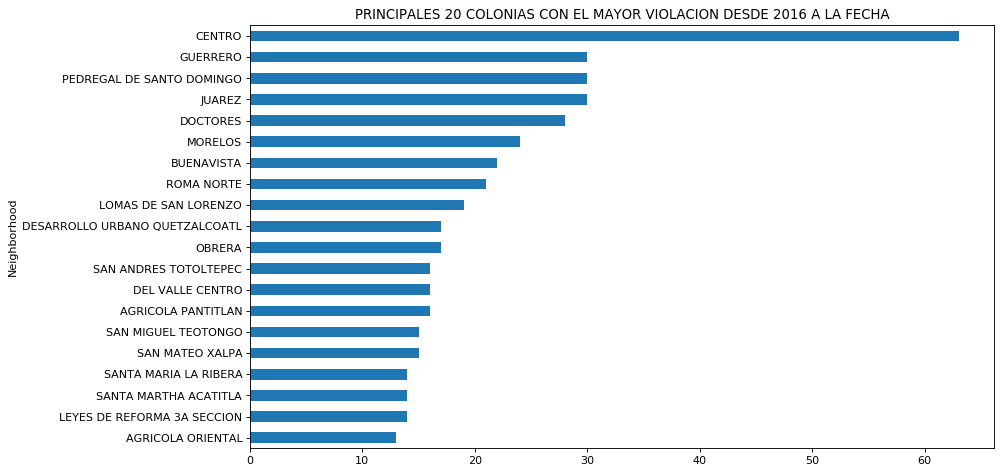

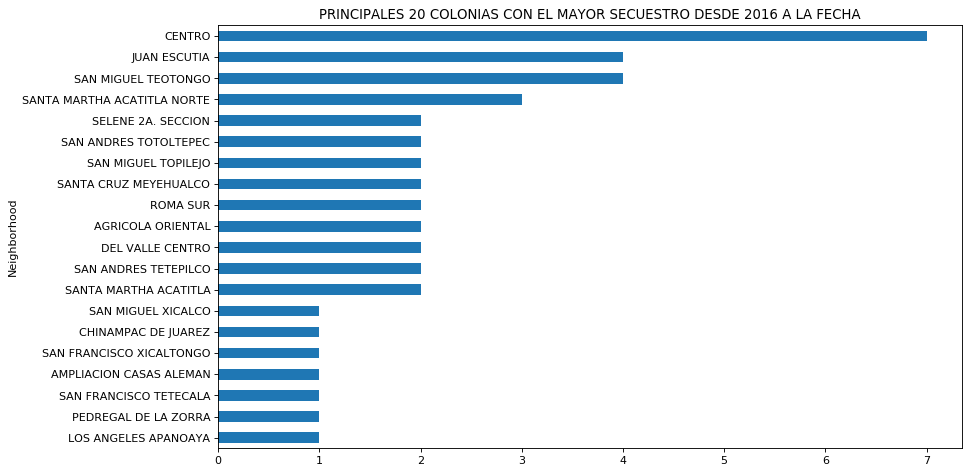

In [13]:
# Top 20 Neighborhood Plots for Violación y Secuestro
plot_categories = ['VIOLACION', 'SECUESTRO']
n = 20
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} DESDE 2016 A LA FECHA')
    top_category_neighborhoods = crime_counts[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods = top_category_neighborhoods.sort_values(ascending=True)
    top_category_neighborhoods.plot.barh(y=category, rot=0)

---

# 3. Analyzing the Data / *Analizando los Datos*<a id="4"></a>

#### 3.1 Separating Crimes per Year / *Separando los Delitos por Año*

In [16]:
year19=['2019']
delitos2019 = delitoscdmx[delitoscdmx['Year'].isin(year19)]
print(delitos2019.shape)
delitos2019.head()

(142763, 9)


,Year,Month,Day,Crime,CrimeID,Borough,Neighborhood,Logitude,Latitude
654214,2019,1,1,EXTORSION,DELITO DE BAJO IMPACTO,CUAJIMALPA DE MORELOS,SAN PABLO CHIMALPA,-99.317786,19.347006
654215,2019,1,1,ROBO A CASA HABITACION SIN VIOLENCIA,DELITO DE BAJO IMPACTO,CUAJIMALPA DE MORELOS,ZENTLAPATL,-99.307454,19.353864
654216,2019,1,1,ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA,DELITO DE BAJO IMPACTO,CUAJIMALPA DE MORELOS,CUAJIMALPA,-99.291536,19.358078
654217,2019,1,1,LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...,DELITO DE BAJO IMPACTO,ALVARO OBREGON,SANTA ROSA XOCHIAC,-99.280482,19.328869
654218,2019,1,1,DAÑO EN PROPIEDAD AJENA INTENCIONAL A CASA HAB...,DELITO DE BAJO IMPACTO,LA MAGDALENA CONTRERAS,AMPLIACION LOMAS DE SAN BERNABE,-99.268164,19.309487


In [17]:
# Create a dataframe which count crimesID
crime_category_onehot19 = pd.get_dummies(delitos2019[['CrimeID']], prefix="", prefix_sep="")
crime_category_onehot19['Neighborhood'] = delitos2019['Neighborhood'] 
fixed_columns19 = [crime_category_onehot19.columns[-1]] + list(crime_category_onehot19.columns[:-1])
crime_category_onehot19 = crime_category_onehot19[fixed_columns19]
# Amount of Crimes in Each Neigborhoods
crime_counts19 = crime_category_onehot19.groupby('Neighborhood').sum()
# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts19.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)
# Add a new column with interests counts value
crime_counts19 = crime_counts19.replace(to_replace=0, value=np.nan)
crime_counts19['CRIMENES'] = crime_counts19.sum(axis='columns')
crime_counts19 = crime_counts19.replace(to_replace=np.nan, value=0)
# Drop Neighborhoods without crimes
crime_counts19 = crime_counts19[(crime_counts19[['CRIMENES']] != 0).all(axis=1)]
# Check the results
crime_counts19.head()

,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
Neighborhood,,,,,,,,,,,,,,,
1 DE MAYO,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,0.0,0.0,9.0
10 DE ABRIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,6.0
10 DE MAYO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,0.0,1.0,7.0
12 DE DICIEMBRE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,5.0
15 DE AGOSTO,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7.0,0.0,7.0,0.0,3.0,0.0,1.0,20.0


#### 3.2 Checking the Top Neighborhoods with Crimes / *Revisando las Principales Colonias con Delitos*

In [19]:
# Make top 20
crime_counts19b = crime_counts19
crime_counts19b = crime_counts19b.replace(to_replace=np.nan, value=0).reset_index()
crimes = crime_counts19b[['Neighborhood', 'CRIMENES']].copy()
crimes['CRIMENES'] = crimes['CRIMENES'].astype(int)
crimes.set_index('Neighborhood', inplace=True)
crimes.sort_values(by='CRIMENES',ascending=True,inplace=True)
df_top20=crimes['CRIMENES'].tail(20)
df_top20

Neighborhood
SANTA MARIA LA RIBERA              156
PORTALES SUR                       169
TACUBAYA                           186
JUAREZ                             192
CENTRAL DE ABASTO                  197
NARVARTE                           198
GRANJAS MEXICO                     222
DEL VALLE CENTRO                   231
ROMA NORTE                         232
MORELOS                            247
DESARROLLO URBANO QUETZALCOATL     250
ZONA CENTRO                        251
ANAHUAC                            259
BUENAVISTA                         262
TACUBA                             271
GUERRERO                           298
DOCTORES                           299
AGRICOLA PANTITLAN                 374
AGRICOLA ORIENTAL                  378
CENTRO                            1038
Name: CRIMENES, dtype: int64

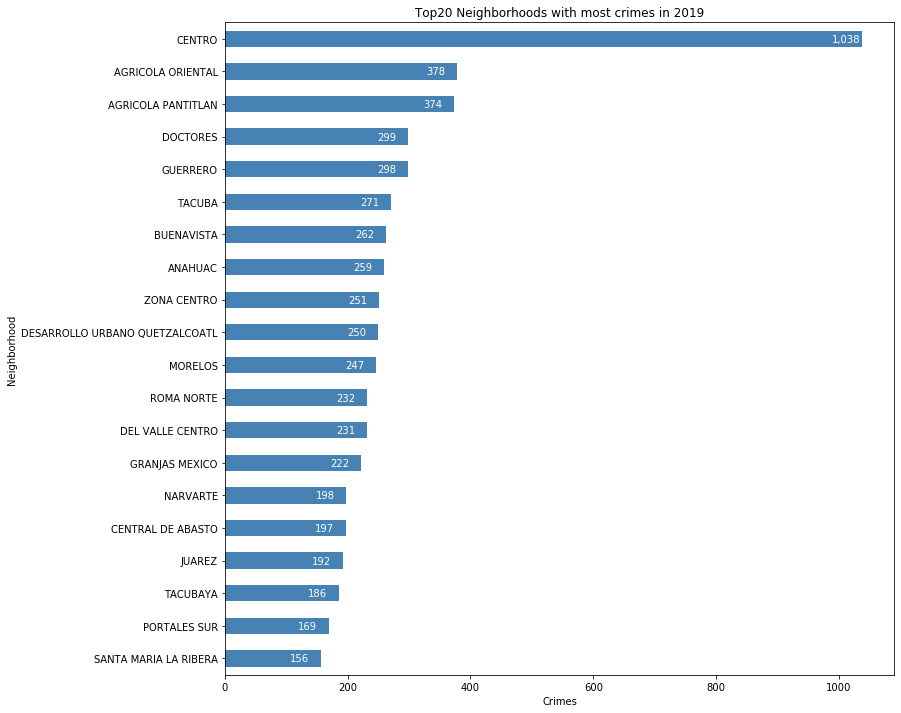

In [20]:
df_top20.plot(kind='barh', figsize=(12,12), color='steelblue')
plt.xlabel('Crimes')
plt.title('Top20 Neighborhoods with most crimes in 2019')
for index, value in enumerate(df_top20): 
    label = format(int(value), ',')
    plt.annotate(label, xy=(value - 50, index - 0.10), color='white')
plt.show()

#### 3.3 Checking Crimes in Other Years / *Revisando Delitos de Otros Años*

In [22]:
# Creating data sets for the other years
year18=['2018']
year17=['2017']
year16=['2016', '2015']
delitos2018 = delitoscdmx[delitoscdmx['Year'].isin(year18)]
delitos2017 = delitoscdmx[delitoscdmx['Year'].isin(year17)]
delitos2016 = delitoscdmx[delitoscdmx['Year'].isin(year16)]
print('Cantidad de delitos en 2019: ',delitos2019.shape[0])
print('Cantidad de delitos en 2018: ',delitos2018.shape[0])
print('Cantidad de delitos en 2017: ',delitos2017.shape[0])
print('Cantidad de delitos en 2016: ',delitos2016.shape[0])

Cantidad de delitos en 2019:  142763
Cantidad de delitos en 2018:  245379
Cantidad de delitos en 2017:  218615
Cantidad de delitos en 2016:  190220


In [23]:
# Create a dataframe which count crimesID
crime_category_onehot18 = pd.get_dummies(delitos2018[['CrimeID']], prefix="", prefix_sep="")
crime_category_onehot18['Neighborhood'] = delitos2018['Neighborhood'] 
fixed_columns18 = [crime_category_onehot18.columns[-1]] + list(crime_category_onehot18.columns[:-1])
crime_category_onehot18 = crime_category_onehot18[fixed_columns18]
# Amount of Crimes in Each Neigborhoods
crime_counts18 = crime_category_onehot18.groupby('Neighborhood').sum()
# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts18.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)
# Add a new column with interests counts value
crime_counts18 = crime_counts18.replace(to_replace=0, value=np.nan)
crime_counts18['CRIMENES'] = crime_counts18.sum(axis='columns')
crime_counts18 = crime_counts18.replace(to_replace=np.nan, value=0)
# Drop Neighborhoods without crimes
crime_counts18 = crime_counts18[(crime_counts18[['CRIMENES']] != 0).all(axis=1)]
# Check the results
crime_counts18.head()

,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
Neighborhood,,,,,,,,,,,,,,,
1 DE MAYO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0
10 DE ABRIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0
10 DE MAYO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,12.0,0.0,2.0,0.0,1.0,19.0
12 DE DICIEMBRE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
15 DE AGOSTO,0.0,0.0,1.0,0.0,0.0,1.0,0.0,9.0,0.0,10.0,0.0,2.0,0.0,1.0,24.0


In [24]:
# Create a dataframe which count crimesID
crime_category_onehot17 = pd.get_dummies(delitos2017[['CrimeID']], prefix="", prefix_sep="")
crime_category_onehot17['Neighborhood'] = delitos2017['Neighborhood'] 
fixed_columns17 = [crime_category_onehot17.columns[-1]] + list(crime_category_onehot17.columns[:-1])
crime_category_onehot17 = crime_category_onehot17[fixed_columns17]
# Amount of Crimes in Each Neigborhoods
crime_counts17 = crime_category_onehot17.groupby('Neighborhood').sum()
# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts17.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)
# Add a new column with interests counts value
crime_counts17 = crime_counts17.replace(to_replace=0, value=np.nan)
crime_counts17['CRIMENES'] = crime_counts17.sum(axis='columns')
crime_counts17 = crime_counts17.replace(to_replace=np.nan, value=0)
# Drop Neighborhoods without crimes
crime_counts17 = crime_counts17[(crime_counts17[['CRIMENES']] != 0).all(axis=1)]
# Check the results
crime_counts17.head()

,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
Neighborhood,,,,,,,,,,,,,,,
1 DE MAYO,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,5.0
10 DE ABRIL,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
10 DE MAYO,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,3.0,0.0,1.0,0.0,0.0,8.0
12 DE DICIEMBRE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,4.0
15 DE AGOSTO,1.0,0.0,1.0,0.0,1.0,2.0,0.0,3.0,1.0,11.0,0.0,3.0,0.0,0.0,23.0


In [25]:
# Create a dataframe which count crimesID
crime_category_onehot16 = pd.get_dummies(delitos2016[['CrimeID']], prefix="", prefix_sep="")
crime_category_onehot16['Neighborhood'] = delitos2016['Neighborhood'] 
fixed_columns16 = [crime_category_onehot16.columns[-1]] + list(crime_category_onehot16.columns[:-1])
crime_category_onehot16 = crime_category_onehot16[fixed_columns16]
# Amount of Crimes in Each Neigborhoods
crime_counts16 = crime_category_onehot16.groupby('Neighborhood').sum()
# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts16.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)
# Add a new column with interests counts value
crime_counts16 = crime_counts16.replace(to_replace=0, value=np.nan)
crime_counts16['CRIMENES'] = crime_counts16.sum(axis='columns')
crime_counts16 = crime_counts16.replace(to_replace=np.nan, value=0)
# Drop Neighborhoods without crimes
crime_counts16 = crime_counts16[(crime_counts16[['CRIMENES']] != 0).all(axis=1)]
# Check the results
crime_counts16.head()

,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
Neighborhood,,,,,,,,,,,,,,,
1 DE MAYO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0
10 DE ABRIL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,3.0
10 DE MAYO,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,4.0
12 DE DICIEMBRE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0
15 DE AGOSTO,0.0,1.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,7.0,0.0,3.0,0.0,0.0,17.0


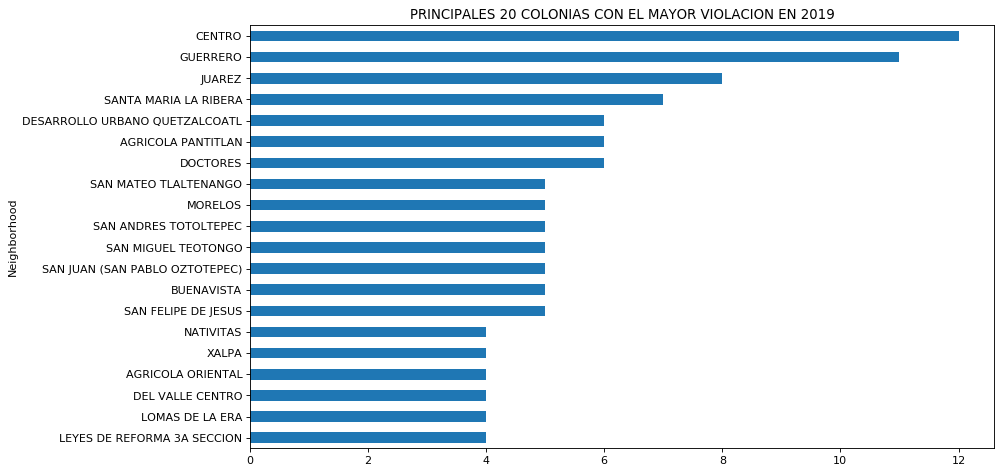

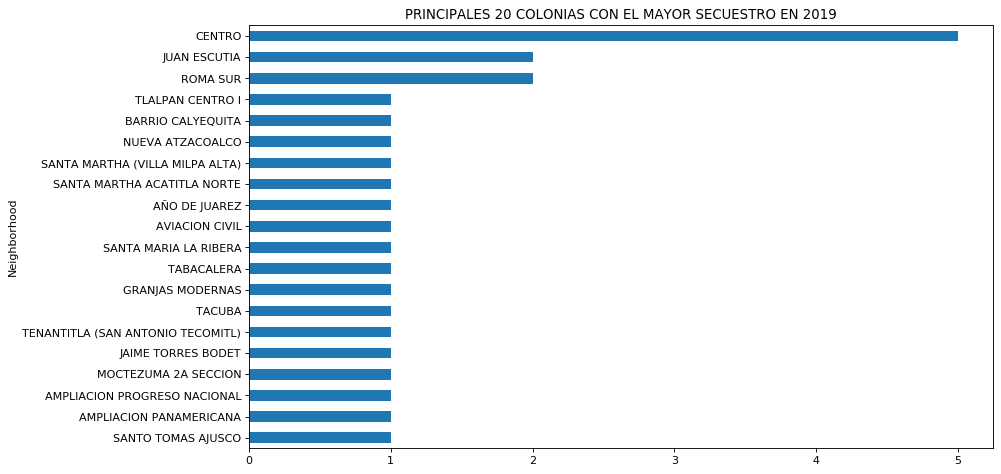

In [26]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2019
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2019')
    top_category_neighborhoods19 = crime_counts19[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods19 = top_category_neighborhoods19.sort_values(ascending=True)
    top_category_neighborhoods19.plot.barh(y=category, rot=0)

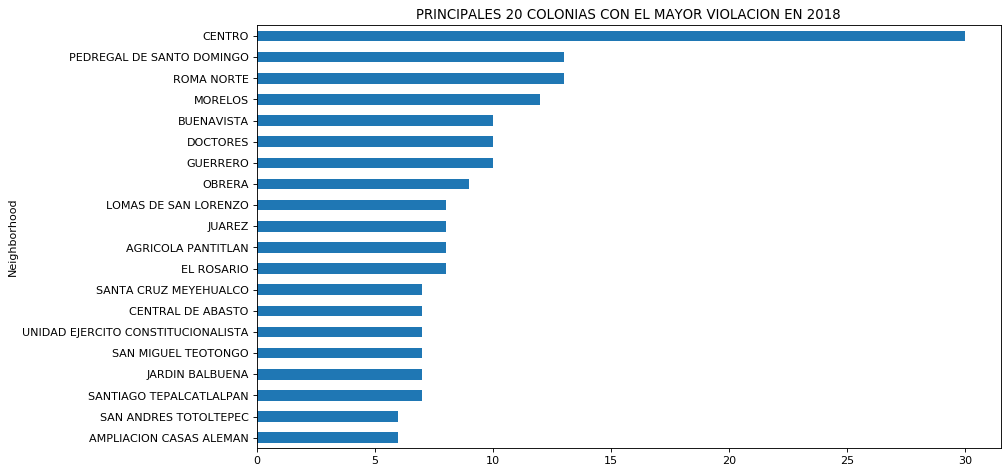

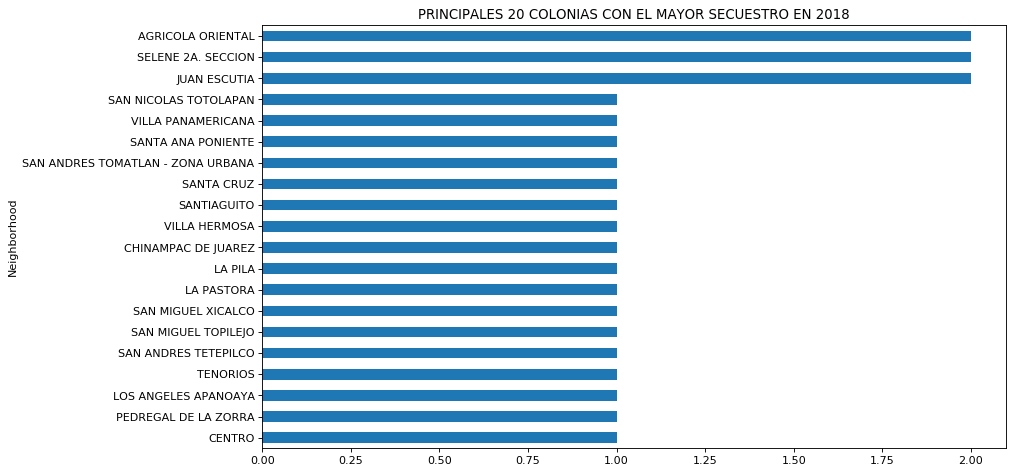

In [27]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2018
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2018')
    top_category_neighborhoods18 = crime_counts18[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods18 = top_category_neighborhoods18.sort_values(ascending=True)
    top_category_neighborhoods18.plot.barh(y=category, rot=0)

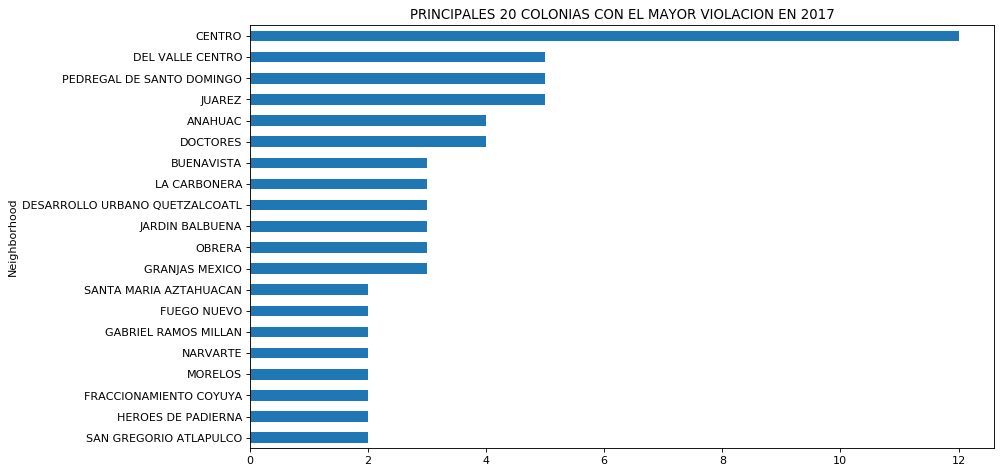

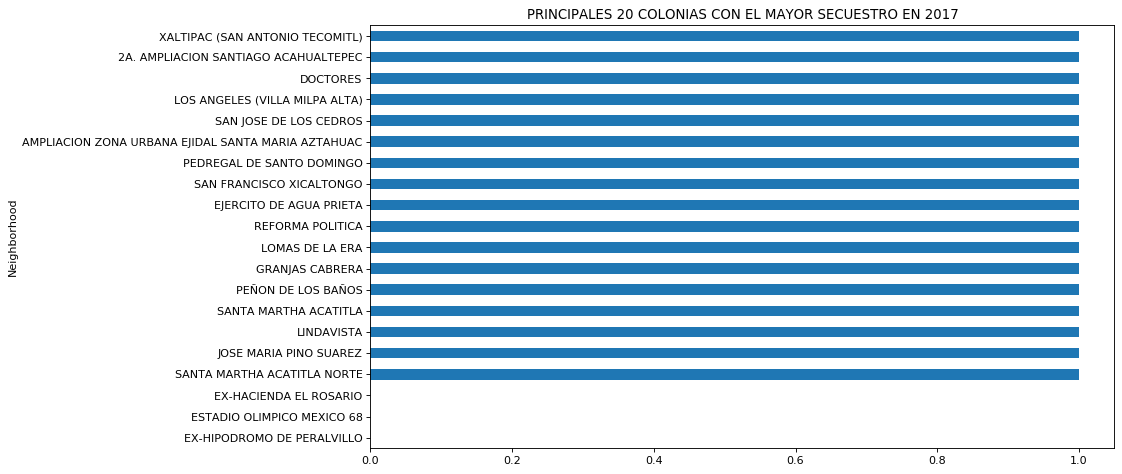

In [28]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2017
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2017')
    top_category_neighborhoods17 = crime_counts17[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods17 = top_category_neighborhoods17.sort_values(ascending=True)
    top_category_neighborhoods17.plot.barh(y=category, rot=0)

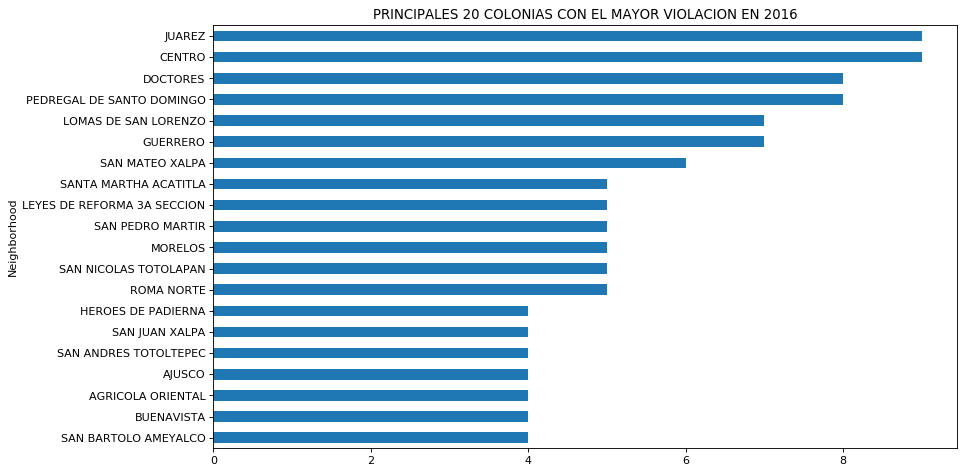

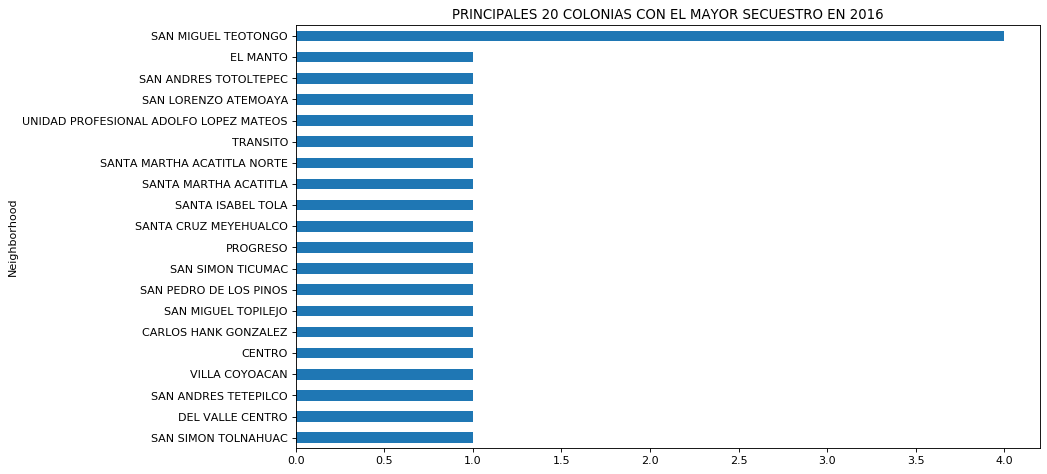

In [29]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2016
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2016')
    top_category_neighborhoods16 = crime_counts16[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods16 = top_category_neighborhoods16.sort_values(ascending=True)
    top_category_neighborhoods16.plot.barh(y=category, rot=0)

#### 3.3 Clustering the Neighborhoods by Number of Crimes / *Agrupando las Colonias por Número de Delitos*

In [30]:
# Create a new dataframe for crime counts
crime_counts19a = crime_counts19
crime_counts19a = crime_counts19a.replace(to_replace=np.nan, value=0).reset_index()
crime_value = crime_counts19a[['Neighborhood', 'CRIMENES']].copy()
crime_value.set_index('Neighborhood', inplace=True)
crime_value.head()

,CRIMENES
Neighborhood,
1 DE MAYO,9.0
10 DE ABRIL,6.0
10 DE MAYO,7.0
12 DE DICIEMBRE,5.0
15 DE AGOSTO,20.0


In [31]:
# Make a dataframe with CRIMENES 
type = ['CRIMENES']
# For each venue category, determine the percentage of entities in each neighborhood
crime_totals = {}
for category in type:
    crime_totals[category] = crime_value[category].sum()

crime_mean = pd.DataFrame()
for category, total in crime_totals.items():
    crime_mean[category] = crime_value[category].apply(lambda x: x / total)
crime_mean = crime_mean.reindex(sorted(crime_mean.columns), axis=1).reset_index()
crime_mean.head(5)

,Neighborhood,CRIMENES
0,1 DE MAYO,0.000308
1,10 DE ABRIL,0.000205
2,10 DE MAYO,0.000240
3,12 DE DICIEMBRE,0.000171
4,15 DE AGOSTO,0.000685


In [32]:
# Define Clusters en 5
kclusters = 5

crime_grouped_clustering = crime_mean.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(crime_grouped_clustering)

kmeans.labels_

array([0, 0, 0, ..., 0, 2, 0], dtype=int32)

In [33]:
# Reset Index y2019  Crimes dataframe
crime_counts19 = crime_counts19.reset_index()

In [34]:
# Get new dataframe with all the columns
crime_counts19.insert(1,'Cluster', kmeans.labels_)
clustercolonias = coloniascdmx
clustercolonias = clustercolonias.join(crime_counts19.set_index('Neighborhood'), on='COLONIA').dropna(axis=0)
clustercolonias['Cluster'] = clustercolonias['Cluster'].astype(int)
clustercolonias.head(10)

,COLONIA,ALCALDIA,Latitude,Longitude,Cluster,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
3,IRRIGACION,MIGUEL HIDALGO,19.442955,-99.209936,3,1.0,0.0,0.0,1.0,5.0,2.0,0.0,0.0,0.0,11.0,0.0,8.0,0.0,0.0,28.0
6,IGNACIO MANUEL ALTAMIRANO,MIGUEL HIDALGO,19.463144,-99.196828,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,LEGARIA,MIGUEL HIDALGO,19.455531,-99.193048,3,0.0,1.0,0.0,0.0,9.0,2.0,1.0,0.0,7.0,9.0,0.0,1.0,0.0,1.0,31.0
10,ADOLFO LOPEZ MATEOS,VENUSTIANO CARRANZA,19.420052,-99.072184,3,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,2.0,24.0,0.0,6.0,0.0,0.0,38.0
22,SANTA CRUZ AVIACION,VENUSTIANO CARRANZA,19.422304,-99.097215,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7.0,2.0,3.0,0.0,1.0,16.0
23,VALENTIN GOMEZ FARIAS,VENUSTIANO CARRANZA,19.416184,-99.093575,3,0.0,1.0,1.0,0.0,6.0,0.0,0.0,0.0,4.0,3.0,0.0,9.0,0.0,1.0,25.0
24,PROGRESISTA,VENUSTIANO CARRANZA,19.436092,-99.109345,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,5.0,0.0,15.0,0.0,1.0,27.0
26,NICOLAS BRAVO,VENUSTIANO CARRANZA,19.453898,-99.123153,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,0.0,0.0,9.0
27,SEVILLA,VENUSTIANO CARRANZA,19.410733,-99.123113,0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,5.0,0.0,6.0,0.0,1.0,0.0,0.0,17.0
29,MIGUEL HIDALGO,VENUSTIANO CARRANZA,19.435990,-99.106836,3,2.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,2.0,13.0,0.0,17.0,0.0,1.0,45.0


#### 3.4 Showing the Clusters Results / *Mostrando los Resultados de Grupos*

In [35]:
# Make the results a dataframe to present the clusters
values = clustercolonias.groupby('Cluster')['Cluster'].count()
values

Cluster
0    470
1      3
2     18
3    151
Name: Cluster, dtype: int64

In [36]:
# Showing results in Cluster 3
print('This cluster have', values.loc[3],'Neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 3, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 151 Neighborhoods


,COLONIA,Cluster,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
3,IRRIGACION,3,1.0,0.0,0.0,1.0,5.0,2.0,0.0,0.0,0.0,11.0,0.0,8.0,0.0,0.0,28.0
7,LEGARIA,3,0.0,1.0,0.0,0.0,9.0,2.0,1.0,0.0,7.0,9.0,0.0,1.0,0.0,1.0,31.0
10,ADOLFO LOPEZ MATEOS,3,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,2.0,24.0,0.0,6.0,0.0,0.0,38.0
23,VALENTIN GOMEZ FARIAS,3,0.0,1.0,1.0,0.0,6.0,0.0,0.0,0.0,4.0,3.0,0.0,9.0,0.0,1.0,25.0
24,PROGRESISTA,3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,5.0,0.0,15.0,0.0,1.0,27.0
29,MIGUEL HIDALGO,3,2.0,1.0,1.0,0.0,8.0,0.0,0.0,0.0,2.0,13.0,0.0,17.0,0.0,1.0,45.0
30,COPILCO UNIVERSIDAD,3,0.0,0.0,1.0,0.0,3.0,1.0,0.0,5.0,0.0,13.0,0.0,5.0,0.0,0.0,28.0
35,TORRE BLANCA,3,0.0,0.0,1.0,1.0,6.0,1.0,1.0,0.0,1.0,23.0,0.0,7.0,0.0,1.0,42.0
36,UN HOGAR PARA NOSOTROS,3,0.0,0.0,0.0,0.0,16.0,1.0,0.0,7.0,0.0,6.0,0.0,3.0,0.0,1.0,34.0
44,FELIPE ANGELES,3,1.0,0.0,1.0,0.0,5.0,1.0,1.0,5.0,2.0,5.0,0.0,5.0,0.0,1.0,27.0


In [37]:
# Showing results in Cluster 2
print('This cluster have', values.loc[2],'Neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 2, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 18 Neighborhoods


,COLONIA,Cluster,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
99,GUADALUPE TEPEYAC,2,0.0,1.0,1.0,2.0,16.0,2.0,0.0,1.0,2.0,36.0,1.0,21.0,0.0,0.0,83.0
165,RESIDENCIAL ZACATENCO,2,1.0,1.0,0.0,0.0,8.0,3.0,0.0,16.0,2.0,25.0,0.0,22.0,0.0,1.0,79.0
290,TEPEYAC INSURGENTES,2,1.0,0.0,2.0,1.0,3.0,2.0,1.0,25.0,1.0,27.0,2.0,19.0,0.0,3.0,87.0
307,DEL CARMEN,2,5.0,1.0,0.0,0.0,4.0,1.0,1.0,0.0,2.0,18.0,0.0,54.0,0.0,3.0,89.0
366,EL ROSARIO,2,3.0,1.0,2.0,2.0,9.0,3.0,2.0,12.0,11.0,50.0,0.0,37.0,1.0,0.0,133.0
627,EL ROSARIO,2,3.0,1.0,2.0,2.0,9.0,3.0,2.0,12.0,11.0,50.0,0.0,37.0,1.0,0.0,133.0
728,PROVIDENCIA,2,3.0,1.0,2.0,1.0,5.0,1.0,0.0,0.0,6.0,21.0,1.0,29.0,0.0,3.0,73.0
749,TRANSITO,2,2.0,2.0,1.0,1.0,5.0,0.0,0.0,11.0,4.0,40.0,0.0,15.0,0.0,1.0,82.0
981,SAN RAFAEL,2,0.0,1.0,1.0,3.0,15.0,1.0,1.0,5.0,2.0,30.0,0.0,16.0,0.0,2.0,77.0
1004,TABACALERA,2,2.0,0.0,0.0,2.0,9.0,0.0,0.0,45.0,2.0,65.0,0.0,7.0,1.0,3.0,136.0


In [38]:
# Showing results in Cluster 1
print('This cluster have', values.loc[1],'Neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 1, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 3 Neighborhoods


,COLONIA,Cluster,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
748,JUAREZ,1,3.0,0.0,2.0,3.0,24.0,0.0,2.0,32.0,2.0,94.0,1.0,21.0,0.0,8.0,192.0
1604,TACUBAYA,1,1.0,0.0,1.0,2.0,25.0,2.0,2.0,68.0,1.0,66.0,0.0,15.0,0.0,3.0,186.0
1607,TACUBA,1,4.0,3.0,2.0,5.0,62.0,5.0,2.0,41.0,12.0,118.0,0.0,13.0,1.0,3.0,271.0


In [39]:
# Showing results in Cluster 0
print('This cluster have', values.loc[0],'Neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 0, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 470 Neighborhoods


,COLONIA,Cluster,HOMICIDIO DOLOSO,LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO,ROBO A CASA HABITACION CON VIOLENCIA,ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA,ROBO A NEGOCIO CON VIOLENCIA,ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA,ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA,ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA,ROBO A REPARTIDOR CON Y SIN VIOLENCIA,ROBO A TRANSEUNTE EN VIA PUBLICA CON Y SIN VIOLENCIA,ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA,ROBO DE VEHICULO CON Y SIN VIOLENCIA,SECUESTRO,VIOLACION,CRIMENES
6,IGNACIO MANUEL ALTAMIRANO,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22,SANTA CRUZ AVIACION,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,7.0,2.0,3.0,0.0,1.0,16.0
26,NICOLAS BRAVO,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,4.0,0.0,0.0,9.0
27,SEVILLA,0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,5.0,0.0,6.0,0.0,1.0,0.0,0.0,17.0
31,5 DE MAYO,0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,3.0,0.0,3.0,0.0,0.0,11.0
34,CHIMALISTAC,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.0,0.0,6.0,0.0,0.0,13.0
37,PLUTARCO ELIAS CALLES,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0.0,13.0,0.0,0.0,19.0
38,PENSIL SUR,0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,0.0,11.0
40,ALVARO OBREGON,0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,11.0,0.0,7.0,0.0,0.0,23.0
41,JANITZIO,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.0,7.0,0.0,0.0,17.0


# 4. Map with Markers / *Mapa con Marcadores*<a id="6"></a>

#### 4.1 Creating a Map of Neighborhoods clustering by crimes with markers / *Creando un mapa de las colonias agrupadas por delitos con marcadores*

In [40]:
# create map
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude = 19.4195042636
longitude = -99.1387615628
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, crimes in zip(clustercolonias['Latitude'], clustercolonias['Longitude'], clustercolonias['COLONIA'], clustercolonias['Cluster'], clustercolonias['CRIMENES']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Crimenes ' + str(crimes), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [41]:
# Saving the map for document purposes
map_clusters.save('map_clusters.html')

Code created by Data Scientist David Arturo Balcázar Amador on August 2019  
*Código creado por el Científico de Datos David Arturo Balcázar Amador en Agosto de 2019*